# Lecture 22: Ewald summation

Recall the potential of an infinite chain of ions with alternating charges,

$$
\Phi(x,y) = \sum_{n=-\infty}^\infty \frac{(-1)^n}{\sqrt{(x-n)^2 + y^2}}
$$

In [1]:
using PyPlot
PyPlot.svg(true);

In [2]:
function Φ_naive(x, y; N=100)
    """ Naive summation of the potential from -N to N
    """
    
    S = 1.0/sqrt(x^2 + y^2) # S_0
    for n=1:N
        # add +n and -n terms
        S += (-1)^n/sqrt((x - n)^2 + y^2) + (-1)^n/sqrt((x + n)^2 + y^2)
    end
    
    S
end

Φ_naive (generic function with 1 method)

In [3]:
# slow convergence
exact = Φ_naive(1.0, 0.2; N=1e8)

-3.648639147264339

In [4]:
Φ_naive(1.0, 0.2; N=10) - exact

0.09586658797511927

## Window functions 
Consider the Coulomb potential
$$
\phi(r) = \frac{1}{r}.
$$

We break it up into a short-ranged and a long ranged part using a Window function which decays rapidly:

$$
\phi_{short}(r) = W(r) \phi(r)
$$
$$
\phi_{long}(r) = (1 - W(r)) \phi(r).
$$

Then, the local potential

$$
\Phi_{local}(\mathbf{r}) = \sum_n \phi_{short}(| \mathbf{r} - \mathbf{r}_n|)
$$

decays quickly in real space, while the distant potential

$$
\Phi_{distant}(\mathbf{r}) = \sum_n \phi_{long}(| \mathbf{r} - \mathbf{r}_n|)
$$

decays rapidly in Fourier space (it varies slowly in real space)

In [5]:
# example

ϕ(r) = 1.0./r
rs = LinRange(1e-10, 10, 500)

ϕs = ϕ.(rs)

# Window function
W(r) = exp.(-r)

ϕ_shorts = W.(rs).*ϕs
ϕ_longs = (1.0 .- W.(rs)).*ϕs;

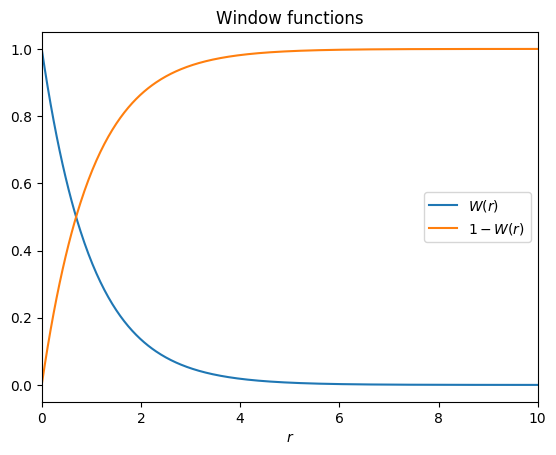

(0, 10)

In [6]:
fig, ax = subplots()

ax.plot(rs, W.(rs), label=L"W(r)")
ax.plot(rs, 1 .- W.(rs), label=L"1 - W(r)")

ax.legend()
ax.set_title("Window functions")
ax.set_xlabel(L"r")
ax.set_xlim(0, 10)

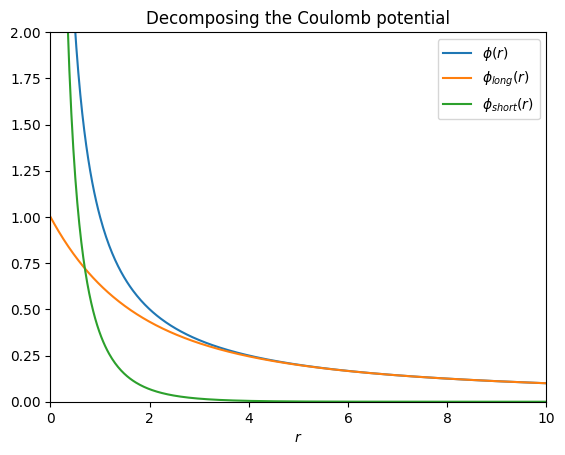

PyObject <matplotlib.legend.Legend object at 0x7fdeb8f827b8>

In [7]:
fig, ax = subplots()

ax.plot(rs, ϕs, label=L"ϕ(r)")
ax.plot(rs, ϕ_longs, label=L"ϕ_{long}(r)")
ax.plot(rs, ϕ_shorts, label=L"ϕ_{short}(r)")

ax.set_title("Decomposing the Coulomb potential")
ax.set_ylim(0, 2)
ax.set_xlim(0, 10)
ax.set_xlabel(L"r")
ax.legend()

# Evaluating the Coulomb potential

We rewrite $\Phi(x,y) = \Phi_{local}(x,y) + \Phi_{distant}(x,y)$
with
$$
\Phi_{local}(x,y) = \sum_{n\in\mathbb{Z}} (-1)^n \phi_{short}(\sqrt{(x-n)^2 + y^2})
$$

and
$$
\Phi_{distant}(x,y) = 4\pi \sum_{\nu=1, \nu\text{ odd}}^\infty \cos(\nu \pi x) \hat{P}_y(\nu \pi),
$$

where we used Poisson summation to evaluate the distant potential using the Fourier transform

$$
\hat{P}_y(k) = \frac{1}{\pi} \int_0^1 \frac{du}{u} e^{-y^2 u^2 - \frac{k^2}{4u^2}}.
$$

This integral must be evaluated numerically.

In [8]:
function simpson_rule(f, a, b, N)
    Δ = (b - a)/N
    h = Δ/2
    
    I = h*f(a)/3 + h*f(b)/3
    for n=1:N-1
        I += h*( 2*f(a + 2*n*h) + 4*f(a+ (2*n-1)*h))/3
    end
    I += 4*h*f(a+ (2*N-1)*h)/3
    
    return I
end

function P_hat(y, k; N=1000)
    """ Evaluate the function P̂_y(k) numerically using Simpson's rule
    """
    integrand(u) = (u == 0.0) ? 0.0 : exp(-y^2 * u^2 - k^2/(4u^2))/(u*π)
    
    return simpson_rule(integrand, 0.0, 1.0, N)
end

P_hat (generic function with 1 method)

In [9]:
using SpecialFunctions # for the complementary error function erfc(x)

ϕ_short(r) = erfc(r)/r

function Φ_local(x, y; N=100)
    """ Evaluate Φ_local by simple summation
    """
    r = sqrt(x^2 + y^2)
    S = ϕ_short(r)
    
    for n=1:N
        r_plus  = sqrt((x - n)^2 + y^2)
        r_minus = sqrt((x + n)^2 + y^2)
        
        S += (-1)^n*(ϕ_short(r_plus) + ϕ_short(r_minus))
    end
    
    return S
end

function Φ_distant(x, y; N=100)
    """ Evaluate Φ_distant by Poisson summation in Fourier space
    """
    S = 0.0
    
    for ν=1:2:N # odd ν
        S += cos(ν*π*x) * P_hat(y, ν*π)
    end
    
    return 4π*S
end

# Ewald summation of the potential
Φ_Ewald(x, y; N=100) = Φ_local(x, y; N=N) + Φ_distant(x, y; N=N)

Φ_Ewald (generic function with 1 method)

In [10]:
# recall that we needed 10^8 iterations of the naive sum for this
exact

-3.648639147264339

In [11]:
Φ_Ewald(1.0, 0.2; N=4)

-3.6486391535712763

In [12]:
function compare_Ewald(x, y)
    Ns = Int64.(trunc.(10.0.^(0:0.1:2)))
    
    exact = Φ_Ewald(x, y; N=1000)
    
    errors_naive = abs.(([ Φ_naive(x, y; N=N) for N in Ns ] .- exact)./exact)
    errors_Ewald = abs.(([ Φ_Ewald(x, y; N=N) for N in Ns ] .- exact)./exact)
    
    return Ns, errors_naive, errors_Ewald
end

compare_Ewald (generic function with 1 method)

In [13]:
Ns, errors_naive, errors_Ewald = compare_Ewald(1.0, 0.2);

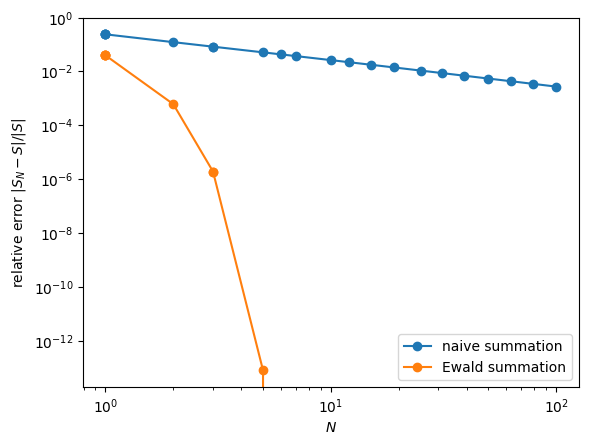

PyObject <matplotlib.legend.Legend object at 0x7fdeb8d0d668>

In [14]:
figure()

loglog(Ns, errors_naive, "o-", label="naive summation")
loglog(Ns, errors_Ewald, "o-", label="Ewald summation")

xlabel(L"N")
ylabel(L"relative error $|S_N - S|/|S|$")
legend()

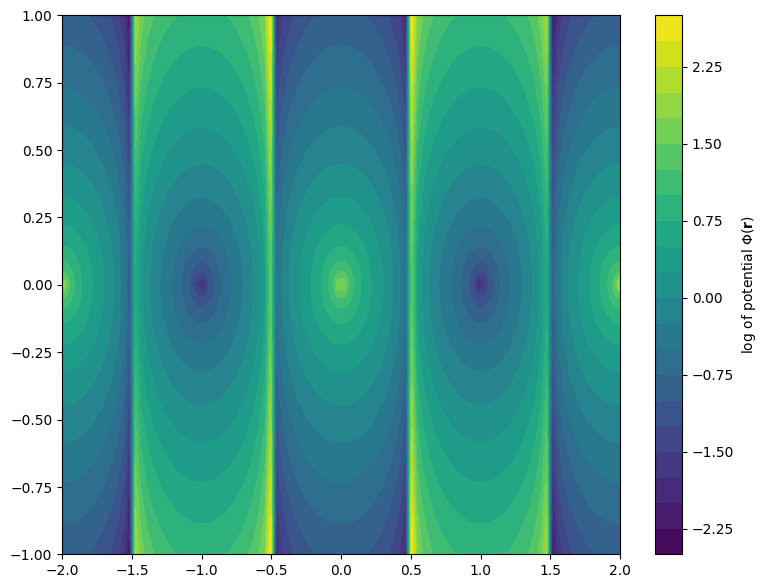

PyObject <matplotlib.colorbar.Colorbar object at 0x7fdeb8c400f0>

In [15]:
# let's map out the potential. Accurately and quickly!

figure(figsize=(9, 7))

# grid on which we plot Φ(x, y)
n = 100
xs = LinRange(-2, 2, n)
ys = LinRange(-1, 1, n)

xgrid = repeat(xs', n, 1)
ygrid = repeat(ys, 1, n)

z = zeros(n, n)

for i in 1:n
    for j in 1:n
        z[i,j] = Φ_Ewald(xgrid[i,j], ygrid[i,j])
        z[i,j] = sign(z[i,j])*log10(abs(z[i,j]))
    end
end

# Contour plot
contourf(xgrid, ygrid, z, 20)
colorbar(label=L"log of potential $Φ(\mathbf{r})$")